## __The Movie Lens Dataset__

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import scipy
import scipy.sparse
data_dir = "data/"
data_shape = (943, 1682)
df = pd.read_csv(data_dir + "u.data", sep="\t", header=None)
values = df.values

In [2]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       100000 non-null  int64
 1   1       100000 non-null  int64
 2   2       100000 non-null  int64
 3   3       100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [4]:
df.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


It is preferable to begin with the MovieLens 100K Dataset for many reasons:
- It is a stable dataset (Released 4/1998)
- It's reasonable size will make life easier for our computer while doing calculations (calculations on bigger datasets might take more time and require more power capacity)

The __*df*__ differs from the rating matrix __*values*__ since the latter is a mathematical tool without column names, just containing the values of the initial dataframe.

## __Data Preprocessing__

In [5]:
 M = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0]-1, values[:, 1]-1)), dtype=float, shape=
     data_shape)

In a sparse matrix, the missing values are implicitly coded as zeros.

In [6]:
# We will extract the non-zero indices to schuffle the corresponding lines and create our train/test data matrices:

rows, cols = M.nonzero() # the indices
data = M.data # the values

n_nonzeros = len(data)
indices = np.arange(n_nonzeros)
np.random.shuffle(indices) # we schuffle randomly the indices

# We create the train/test matrices, using 90% for training and 10 % for testing:
train_size = int(0.9*n_nonzeros)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

M_train = scipy.sparse.csr_matrix((data[train_indices],
                      (rows[train_indices], cols[train_indices])),
                     shape=M.shape)

M_test = scipy.sparse.csr_matrix((data[test_indices],
                     (rows[test_indices], cols[test_indices])),
                    shape=M.shape)


In [7]:
M_train

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 90000 stored elements in Compressed Sparse Row format>

In [8]:
M_test

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>

In [9]:
# We will compute the global mean of ratings given by the users to the movies:

global_mean = M_train.data.mean() # We compute the global mean on the train data, to then center and compute the test error

print(f"The global mean of the ratings given by the users if {global_mean:.1f}.")

The global mean of the ratings given by the users if 3.5.


In [10]:
# We center the data:
M_train_centered = M_train.copy()
M_train_centered.data -= global_mean

# We compute the test error when predicting missing values by the mean:
test_data = M_test.data
test_predictions = np.full(test_data.shape, global_mean)

test_error = np.mean((test_data - test_predictions)**2)
print(f"The test error when predicting missing values is {test_error:.1f}.")

The test error when predicting missing values is 1.3.


The test error is quite high, knowing the ranking vary from 0 to 5.

## __Recommending using SVD__

In [11]:
M_train_centered.shape

(943, 1682)

In [12]:
# We compute the 20 first factors of the SVD of the centered training data:
k = 20  # Number of factors
U, S, Vt = scipy.sparse.linalg.svds(M_train_centered, k=k)

# We sort the values in the descending order:
U, S, Vt = U[:, ::-1], S[::-1], Vt[::-1, :] # We use this slicing method since the scipy library returns the values in a descending order

print("The 20 first factors of the SVD of the centered training data are:", S)

The 20 first factors of the SVD of the centered training data are: [80.88793336 64.59460338 54.65362371 47.76150551 39.66302619 37.22634364
 35.59277879 33.84991078 33.04531253 30.74835524 30.57113668 29.75077742
 28.51687071 28.1372719  27.83624925 27.44272096 27.1854485  26.9997982
 26.49241594 26.34368725]


Number of factors: 1, MSE: 1.16
Number of factors: 2, MSE: 1.11
Number of factors: 3, MSE: 1.10
Number of factors: 4, MSE: 1.09
Number of factors: 5, MSE: 1.08
Number of factors: 6, MSE: 1.07
Number of factors: 7, MSE: 1.07
Number of factors: 8, MSE: 1.06
Number of factors: 9, MSE: 1.05
Number of factors: 10, MSE: 1.05
Number of factors: 11, MSE: 1.05
Number of factors: 12, MSE: 1.05
Number of factors: 13, MSE: 1.05
Number of factors: 14, MSE: 1.05
Number of factors: 15, MSE: 1.05
Number of factors: 16, MSE: 1.05
Number of factors: 17, MSE: 1.05
Number of factors: 18, MSE: 1.05
Number of factors: 19, MSE: 1.06
Number of factors: 20, MSE: 1.06


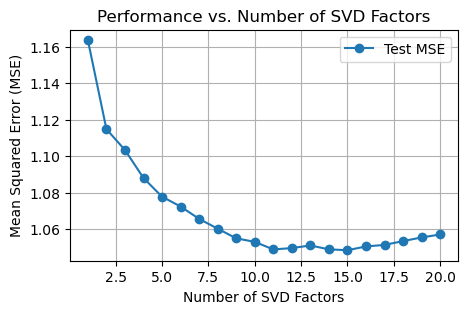

In [13]:
# We will predict the missing test values using the SVD 
# with an increasing number of component (up to 20):

def svd_predict(M_train_centered, M_test, k):
    U, S, Vt = scipy.sparse.linalg.svds(M_train_centered, k=k)
    
    U, S, Vt = U[:, ::-1], S[::-1], Vt[::-1, :] 

    # We reconstruct the matrix with k components:
    S_matrix = np.diag(S)
    M_reconstructed = U @ S_matrix @ Vt
    
    # We add back the global mean to get predictions:
    M_predicted = M_reconstructed + global_mean
    
    # We extract the predictions for the test set:
    test_rows, test_cols = M_test.nonzero()
    test_values = M_test.data
    pred_values = M_predicted[test_rows, test_cols]
    
    # We compute the MSE:
    mse = np.mean((test_values - pred_values) ** 2)
    return mse


# We will evaluate the performance of this approach on the test matrix 
# and plot the resulting performance as a function of the number of factors 
# of the SVD used to perform the reconstruction:
import matplotlib.pyplot as plt

max_components = 20
mses = []

for k in range(1, max_components + 1):
    mse = svd_predict(M_train_centered, M_test, k)
    mses.append(mse)
    print(f"Number of factors: {k}, MSE: {mse:.2f}")

# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(range(1, max_components + 1), mses, marker='o', label='Test MSE')
plt.xlabel('Number of SVD Factors')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Performance vs. Number of SVD Factors')
plt.grid()
plt.legend()
plt.show()

We wan see that the more we keep information, i.e. we keep a large number of factors of the SVD, the better the prediction is (the MSE decreases as the number of factors increases).

## __Recommending using the weighted SVD__

In [14]:
# We implement a weighted SVD using ALS:

def als_penalized_svd(M, W, lambda_reg, k, max_iter=100):
    """
    Perform weighted SVD using Alternating Least Squares (ALS).
    
    Parameters:
    M : np.ndarray (sparse matrix)
        Ratings matrix (n_items x n_users)
    W : np.ndarray
        Weight matrix (n_items x n_users)
    lambda_reg : float
        Regularization parameter
    k : int
        Number of latent factors
    max_iter : int
        Maximum number of iterations

    Returns:
    U : np.ndarray
        User factors
    V : np.ndarray
        Item factors
    """
    U, S, Vt = scipy.sparse.linalg.svds(M, k=k)
    U = U[:, ::-1]
    S = S[::-1]
    Vt = Vt[::-1, :]
    V = Vt.T

    for iteration in range(n_iterations):
        for i in range(U.shape[0]):
            # Get the indices of non-zero ratings for the user
            V_i = V[M[i, :].nonzero()[1], :]
            M_i = M[i, M[i, :].nonzero()[1]].A.flatten()
            if V_i.shape[0] > 0:  # Ensure V_i is not empty
                # Compute the damped least squares solution
                U[i, :] = scipy.sparse.linalg.lsqr(V_i.T @ V_i + lambda_ * np.eye(k), V_i.T @ M_i)[0]

        for j in range(V.shape[0]):
            # Get the indices of non-zero ratings for the item
            U_j = U[M[:, j].nonzero()[0], :]
            M_j = M[M[:, j].nonzero()[0], j].A.flatten()
            if U_j.shape[0] > 0:  # Ensure U_j is not empty
                # Compute the damped least squares solution
                V[j, :] = scipy.sparse.linalg.lsqr(U_j.T @ U_j + lambda_ * np.eye(k), U_j.T @ M_j)[0]

    return U, V

In [15]:
# We implement Funk SVD using SGD:

def funk_svd(M, W, lambda_reg, k, learning_rate=0.01, max_iter=1000):
    """
    Implement Funk SVD algorithm using Stochastic Gradient Descent (SGD).

    Parameters:
    M : np.ndarray
        Ratings matrix (n_items x n_users)
    W : np.ndarray
        Weight matrix (n_items x n_users)
    lambda_reg : float
        Regularization parameter
    k : int
        Number of latent factors
    learning_rate : float
        Learning rate for SGD
    max_iter : int
        Maximum number of iterations

    Returns:
    U : np.ndarray
        User factors
    V : np.ndarray
        Item factors
    """
    n_users, n_items = M.shape
    U = np.random.normal(scale=1./k, size=(n_users, k))
    V = np.random.normal(scale=1./k, size=(n_items, k))

    for _ in range(max_iter):
        for i in range(n_users):
            for j in range(n_items):
                if W[i, j] > 0:  # Only consider known ratings
                    error = M[i, j] - np.dot(U[i, :], V[j, :])
                    # Update user and item factors
                    U[i, :] += learning_rate * (error * V[j, :] - lambda_reg * U[i, :])
                    V[j, :] += learning_rate * (error * U[i, :] - lambda_reg * V[j, :])

    return U, V

The __scikit-surprise__ library provides a better and more simple solution with scikit-learn.

After having installed the surprise package, we can run the following code:

In [16]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare the data for scikit-surprise
ratings = pd.DataFrame({
    'user_id': values[:, 0] - 1,  # Adjusting for zero indexing
    'item_id': values[:, 1] - 1,
    'rating': values[:, 2]
})

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1)

# Train SVD
svd = SVD()
svd.fit(trainset)

# Make predictions
predictions = svd.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)

RMSE: 0.9156


In [ ]:
k = 20
lambda_ = 2
n_iterations = 100

# ALS Method
U_als, V_als = als_penalized_svd(M_train, lambda_, k, n_iterations)
M_als_predicted = U_als @ V_als.T
mse_als = np.mean((M_test.data - M_als_predicted[M_test.nonzero()]) ** 2)

# Funk SVD Method
U_funk, V_funk = funk_svd(M_train, k, n_iterations)
M_funk_predicted = U_funk @ V_funk.T
mse_funk = np.mean((M_test.data - M_funk_predicted[M_test.nonzero()]) ** 2)

# Scikit-Surprise Method
mse_surprise = surprise_svd(M_train, M_test)

# Print results
print(f"MSE for ALS: {mse_als:.4f}")
print(f"MSE for Funk SVD: {mse_funk:.4f}")
print(f"MSE for Scikit-Surprise SVD: {mse_surprise:.4f}")